# Assignment 5.2

### Importing Libraries

In [1]:
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
from tqdm import tqdm
from sklearn.metrics import *
import pandas as pd
import seaborn as sns  
import shutil
import os
import torch.nn.functional as F

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Retriving Data

In [2]:
# Loading data on colab server
drive.mount("./gdrive")
!unzip "./gdrive/My Drive/Copy of A_05_Part_02_Dataset.zip"
source = 'A_05_Part_02_Dataset/Test/'
dest = 'A_05_Part_02_Dataset/Test/Unlabeled/'
os.mkdir('A_05_Part_02_Dataset/Test/Unlabeled')
files = os.listdir(source)
for f in files:
    shutil.move(source+f, dest)

Drive already mounted at ./gdrive; to attempt to forcibly remount, call drive.mount("./gdrive", force_remount=True).


### Loading Data

In [3]:
# directory where data is loaded
data_dir = 'A_05_Part_02_Dataset'

# trans
# Adding data augmentation for better learning
# I calculated the mean and std using code that is present in last cell of the notebook  
train_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.RandomRotation(15),
                                       transforms.RandomHorizontalFlip(0.2),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.518, 0.519, 0.519],
                                                            [0.219, 0.219, 0.219])])

# transforming validation data 
validation_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                       transforms.Normalize([0.518, 0.519, 0.519],
                                                            [0.219, 0.219, 0.219])])

# transforming testing data
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                       transforms.Normalize([0.518, 0.519, 0.519],
                                                            [0.219, 0.219, 0.219])])

# specifying train, test and validation data directories
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
validation_data = datasets.ImageFolder(data_dir + '/Validation', transform=validation_transforms)
test_data = datasets.ImageFolder(data_dir + '/Test', transform=test_transforms)

# Loading Data
# i am using 8 threads and batches of 50 images for each type of data for better performance 
trainloader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True, num_workers = 8)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=20, shuffle=True,num_workers = 8)
testloader = torch.utils.data.DataLoader(test_data, batch_size=20, shuffle=False, num_workers = 8)

# Displaying Loaded data stats
class_names = train_data.classes
print("Training and Validation Classes: ",class_names)
test_classes = test_data.classes
print("Test Classes: ",test_classes)
print(trainloader.dataset)
print(validationloader.dataset)
print(testloader.dataset)

Training and Validation Classes:  ['covid-19', 'normal', 'pneumonia']
Test Classes:  ['Unlabeled']
Dataset ImageFolder
    Number of datapoints: 6200
    Root location: A_05_Part_02_Dataset/Train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               RandomRotation(degrees=(-15, 15), resample=False, expand=False)
               RandomHorizontalFlip(p=0.2)
               ToTensor()
               Normalize(mean=[0.518, 0.519, 0.519], std=[0.219, 0.219, 0.219])
           )
Dataset ImageFolder
    Number of datapoints: 628
    Root location: A_05_Part_02_Dataset/Validation
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.518, 0.519, 0.519], std=[0.219, 0.219, 0.219])
           )
Dataset ImageFolder
    Number of datapoi

In [51]:
class_names = train_data.classes
print("Training and Validation Classes: ",class_names)
test_classes = test_data.classes
print("Test Classes: ",test_classes)

Training and Validation Classes:  ['covid-19', 'normal', 'pneumonia']
Test Classes:  ['Unlabeled']


### Getting Image Names

In [0]:
image_names = [] 
for i in range (629):
    # Getting image names
    b = os.path.split(str(testloader.dataset.samples[i]))[1]  
    f = os.path.splitext(b)[0] 
    image_names.append(f)

### Displaying Images

In [0]:
# Creating function to show images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# creating grid to display batch of images 
def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[str('  ')+class_names[x]+str('  ') for x in classes])

Training images with augmentation


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


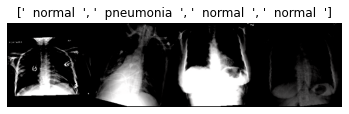

Validation images without augmentation


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


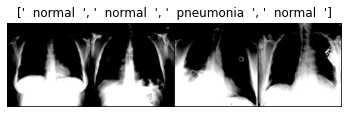

In [12]:
# Get a batch of training data
print('Training images with augmentation')
inputs, classes = next(iter(trainloader))
# displaying training images
show_databatch(inputs[:4], classes[:4])

# Get a batch of testing data
print('Validation images without augmentation')
inputs, classes = next(iter(validationloader))
# displaying testing images
show_databatch(inputs[:4], classes[:4])

### Onehot Encoding
 

In [0]:
def onehot(label,order): # class labels order in data and in csv file is bit different  
    labels = torch.zeros(len(label),3)
    for i in range(len(label)):
        if label[i] == order[0]:
            labels[i] = torch.tensor([1,1,0])  # for covid-19 class
        elif label[i] == order[1]:
            labels[i] = torch.tensor([0,1,0])  # for pneumonia class
        elif label[i] == order[2]:
            labels[i] = torch.tensor([0,0,1])  # for normal class
    return labels

In [14]:
onehot(classes,[0,2,1])

tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 1., 0.]])

### Enabling GPU
#### Must rember that the model predicts well only on GPU so it is must to connect to GPU before executing following code

In [0]:
# Utilizing GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Training Function

In [0]:
# creating a function to train training data in differement experiments using different structures and models 
def train_model(model, epochs, training_data, validation_data, optimizer, criterion, filename):
    # Converting data to GPU processable form if available
    model.to(device)
    model.train()

    # creating arrays to store stats
    training_accuracy = []
    validation_accuracy = []
    training_loss = []
    validation_loss = []

    # Traing data
    for epoch in range(epochs):  # loop over the dataset multiple times
        # to show progress 
        pbar = tqdm(enumerate(training_data))
        # getting each batch for training 
        for i, data in pbar:
            # get the inputs
            inputs, labels = data
            labels = onehot(labels,[0,2,1])
            inputs, labels = inputs.to(device), labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # feedforward
            outputs = model(inputs)
            # computing loss              
            loss = criterion(outputs, labels)
            # backprpagation   
            loss.backward() 
            # updating weights                    
            optimizer.step()  

            # displaying progess
            pbar.set_description(
                'Training Epoch: {}, Loss {},({:.0f}%)'.format(
                    epoch+1,loss.item(), int((100. * i / len(training_data))+1)))
        
        # Displaying stats for current epoch
        # calculating stats on training data for current epoch
        print('\nFor training data')
        train_loss,train_accu,train_precision,train_recall,train_f1,train_confusion = scores(training_data,model,criterion)

        # calculating stats on validation data for current epoch
        print('\nFor validation data')
        valid_loss,valid_accu,valid_precision,valid_recall,valid_f1,valid_confusion = scores(validation_data,model,criterion)
        
        # storing stats in arrays to plot curves
        training_accuracy.append(train_accu)
        validation_accuracy.append(valid_accu)
        training_loss.append(train_loss)
        validation_loss.append(valid_loss)
        print("\nTraining Accuracy = ",train_accu, '\nTraining Loss = ',train_loss, "\nValidation Accuracy = ",valid_accu, '\nValidation Loss = ',valid_loss,"\n")  
    
    # displaing final epoch's stats on training data
    print('Final Stats:\n')
    train_stats = pd.DataFrame([train_loss,train_accu,train_precision,train_recall,train_f1],['Loss','Accuracy','Precision','Recall','F1_Score'],['Training Scores']).T
    print(train_stats)
    print()
    
    # displaing final epoch's stats on validaiton data
    valid_stats = pd.DataFrame([valid_loss,valid_accu,valid_precision,valid_recall,valid_f1],['Loss','Accuracy','Precision','Recall','F1_Score'],['Validation Scores']).T
    print(valid_stats)
    print()

    # displaying confusion matrix for training data
    sns.heatmap(train_confusion, annot=True, fmt='g', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title('Confusion Matrix for Training Data')
    plt.ylim(reversed(plt.ylim()))
    plt.show()
    print()

    # displaying confusion matrix for validation data
    sns.heatmap(valid_confusion, annot=True, fmt='g', cbar=False)
    plt.title('Confusion Matrix for Validation Data')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.ylim(reversed(plt.ylim()))
    plt.show()
    print()

    # plotting cross entropy loss on training and validation data
    plt.title('Loss Curve')
    plt.plot(range(epochs),training_loss, label= 'Training Data')
    plt.plot(range(epochs),validation_loss,label='Validation Data')
    plt.legend()
    plt.show()  
    print()
        
    # plotting accuracy for training and validation data
    plt.title('Accuracy Curve')
    plt.plot(range(epochs),training_accuracy,label= 'Training Data')
    plt.plot(range(epochs),validation_accuracy,label= 'Validation Data')
    plt.legend()
    plt.show()
    
    # saving the model
    torch.save(model.state_dict(), filename)
    

### Calculating Scores

In [0]:
def scores(dataset,model,criterion):
    loss = 0
    predicted = []
    true_labels = []
    model.to(device)
    
    # getting prediction made by the model 
    with torch.no_grad():
        # to display progess
        pbar = tqdm(enumerate(dataset))
        # getting each batch 
        for i, data in pbar:
            # get the inputs
            inputs, labels = data
            labels = onehot(labels,[0,2,1])
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            _,labels = torch.max(labels,1) 
            _,pred = torch.max(torch.round(torch.sigmoid(outputs)),1)
            # print('\n',a,'\n',pred)
            predicted.extend(pred.tolist())
            # storing actutal labels in list
            true_labels.extend(labels.tolist())

            # displaying progress
            pbar.set_description(
                'Calculating Accuracy and Loss: ({:.0f}%)'.format(
                    int((100. * i / len(dataset))+1)))
    
    # calculating loss on whole data
    total_loss = loss/len(dataset)
    # calculating accurate predictions of model on whole data
    accuracy = accuracy_score(true_labels,predicted)*100
    # calculating recall
    recall = recall_score(true_labels,predicted,average='weighted')*100
    # # calculating precision
    precision = precision_score(true_labels,predicted,average='weighted')*100
    # calculating F1_Score
    f1 = f1_score(true_labels,predicted,average='weighted')*100
    # making confusion matrix
    confusion = pd.DataFrame(confusion_matrix(true_labels,predicted),['Covid-19','Pneumonia','Normal'],['Covid-19','Pneumonia','Normal'])
    return total_loss,accuracy,precision,recall,f1,confusion

### Focal Loss

In [0]:
def Focal_Loss(inputs, targets, alpha = 0.25, gamma = 2):
    # flatening one hot matrix for target and predicted labels 
    # in this way we can compare if each class is predicted correctly or not
    inputs = inputs.view(-1)
    targets = targets.view(-1)
    
    # Applying sigmoid non linearity on predicted labels
    pred_prob = torch.sigmoid(inputs)
    
    # Calculating probability of each class
    # here log(prob) is BCE
    prob = (targets * pred_prob) + ((1 - targets) * (1 - pred_prob))

    # Calculating value of alpha for each class
    alpha = targets * alpha + (1 - targets) * (1 - alpha)
    
    # Calculating focal loss
    # formula for focal loss is as following
    # focal loss(t) = - alpha(t) * (1-prob(t))^gamma * log(prob(t)) 
    focal_loss = - alpha * torch.pow((1 - prob), gamma) * torch.log(prob) 
    
    # returning focal loss
    return torch.sum(focal_loss)

### Predicting unlabeled test images

In [0]:
# This function is used to classify test images 
# Here we do not have labeled data 
def predict_images(dataset,model):
    predicted = []
    true_labels = []
    model.to(device)
    
    with torch.no_grad():
        pbar = tqdm(enumerate(dataset))
        for i, data in pbar:
            inputs, labels = data
            labels = onehot(labels,[0,2,1])
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _,labels = torch.max(labels,1) 
            _,pred = torch.max(torch.round(torch.sigmoid(outputs)),1)
            # print('\n',a,'\n',pred)
            predicted.extend(pred.tolist())
            # storing actutal labels in list
            true_labels.extend(labels.tolist())

            pbar.set_description(
                'Predicting Images: ({:.0f}%)'.format(
                    int((100. * i / len(dataset))+1)))
            
    return true_labels, predicted

## Task 1

### VGG-16

#### Loading Model

In [20]:
# Loading VGG-16 pretrained model  
vgg16 = models.vgg16(pretrained=True)
# Replacing predefined FC layers with desired layers
features = []
num_features =  1024
# as we have 3 classes
num_classes = 3
features.extend([nn.Linear(25088, num_features)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout()])
features.extend([nn.Linear(num_features, num_classes)])
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#### Training Model

Training Epoch: 1, Loss 0.20639678835868835,(100%): : 310it [03:46,  1.37it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:58,  2.61it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.45it/s]


Training Accuracy =  88.29032258064517 
Training Loss =  0.2109631914405092 
Validation Accuracy =  85.50955414012739 
Validation Loss =  0.30227852013194934 




Training Epoch: 2, Loss 0.056986529380083084,(100%): : 310it [03:47,  1.36it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:56,  2.67it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.40it/s]


Training Accuracy =  91.2258064516129 
Training Loss =  0.15115910412803774 
Validation Accuracy =  88.85350318471338 
Validation Loss =  0.1847891405923292 




Training Epoch: 3, Loss 0.017073115333914757,(100%): : 310it [03:47,  1.37it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:55,  2.69it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.39it/s]


Training Accuracy =  93.30645161290323 
Training Loss =  0.11539802399253653 
Validation Accuracy =  91.56050955414013 
Validation Loss =  0.14664965478004888 




Training Epoch: 4, Loss 0.06269417703151703,(100%): : 310it [03:46,  1.37it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:57,  2.64it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.37it/s]


Training Accuracy =  93.03225806451613 
Training Loss =  0.1133526046069399 
Validation Accuracy =  92.03821656050955 
Validation Loss =  0.13560984656214714 




Training Epoch: 5, Loss 0.044589824974536896,(100%): : 310it [03:46,  1.37it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:54,  2.70it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.37it/s]


Training Accuracy =  94.14516129032258 
Training Loss =  0.10016632329432233 
Validation Accuracy =  92.51592356687898 
Validation Loss =  0.1251393345883116 




Training Epoch: 6, Loss 0.07331420481204987,(100%): : 310it [03:47,  1.36it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:56,  2.66it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.36it/s]


Training Accuracy =  94.9032258064516 
Training Loss =  0.08904773838247262 
Validation Accuracy =  93.47133757961782 
Validation Loss =  0.12936903029913083 




Training Epoch: 7, Loss 0.0599796287715435,(100%): : 310it [03:46,  1.37it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:55,  2.69it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.36it/s]


Training Accuracy =  95.09677419354838 
Training Loss =  0.09145775105684034 
Validation Accuracy =  94.10828025477707 
Validation Loss =  0.11677041638176888 




Training Epoch: 8, Loss 0.1228761151432991,(100%): : 310it [03:46,  1.37it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:58,  2.61it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.30it/s]


Training Accuracy =  95.29032258064515 
Training Loss =  0.08494657385012795 
Validation Accuracy =  93.78980891719745 
Validation Loss =  0.11714935686904937 




Training Epoch: 9, Loss 0.019810723140835762,(100%): : 310it [03:46,  1.37it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:58,  2.63it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.30it/s]


Training Accuracy =  95.53225806451613 
Training Loss =  0.07474027284976816 
Validation Accuracy =  94.90445859872611 
Validation Loss =  0.10078995887306519 




Training Epoch: 10, Loss 0.02129281871020794,(100%): : 310it [03:46,  1.37it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:56,  2.66it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.32it/s]


Training Accuracy =  96.53225806451613 
Training Loss =  0.06226327595556335 
Validation Accuracy =  94.26751592356688 
Validation Loss =  0.11350133451924194 




Training Epoch: 11, Loss 0.13127195835113525,(100%): : 310it [03:46,  1.37it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:58,  2.62it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.38it/s]


Training Accuracy =  94.2258064516129 
Training Loss =  0.09341100356691788 
Validation Accuracy =  91.56050955414013 
Validation Loss =  0.16147879490745254 




Training Epoch: 12, Loss 0.05846838280558586,(100%): : 310it [03:46,  1.37it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:58,  2.63it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.38it/s]


Training Accuracy =  96.30645161290322 
Training Loss =  0.06560466407287506 
Validation Accuracy =  94.42675159235668 
Validation Loss =  0.12214823537215125 




Training Epoch: 13, Loss 0.06491944938898087,(100%): : 310it [03:46,  1.37it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:57,  2.64it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.43it/s]


Training Accuracy =  95.12903225806451 
Training Loss =  0.0842730879723545 
Validation Accuracy =  92.35668789808918 
Validation Loss =  0.1327324739540927 




Training Epoch: 14, Loss 0.08969082683324814,(100%): : 310it [03:46,  1.37it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:59,  2.59it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.29it/s]


Training Accuracy =  95.96774193548387 
Training Loss =  0.06681565410577722 
Validation Accuracy =  93.94904458598727 
Validation Loss =  0.12779247378057335 




Training Epoch: 15, Loss 0.005005658604204655,(100%): : 310it [03:47,  1.36it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:58,  2.61it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 32it [00:14,  2.26it/s]


Training Accuracy =  97.38709677419355 
Training Loss =  0.04627124457695191 
Validation Accuracy =  94.42675159235668 
Validation Loss =  0.13272191365103936 




Training Epoch: 16, Loss 0.01852872036397457,(100%): : 310it [03:47,  1.36it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:57,  2.65it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.41it/s]


Training Accuracy =  97.79032258064517 
Training Loss =  0.04141739409439446 
Validation Accuracy =  94.42675159235668 
Validation Loss =  0.10167185198224615 




Training Epoch: 17, Loss 0.03470199555158615,(100%): : 310it [03:47,  1.37it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:58,  2.62it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.35it/s]


Training Accuracy =  97.79032258064517 
Training Loss =  0.049834489754791704 
Validation Accuracy =  94.26751592356688 
Validation Loss =  0.12084220146061853 




Training Epoch: 18, Loss 0.09563513100147247,(100%): : 310it [03:47,  1.37it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:58,  2.61it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 32it [00:14,  2.26it/s]


Training Accuracy =  97.91935483870968 
Training Loss =  0.03676148935356328 
Validation Accuracy =  94.26751592356688 
Validation Loss =  0.1528986567609536 




Training Epoch: 19, Loss 0.08043461292982101,(100%): : 310it [03:47,  1.36it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:58,  2.61it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 32it [00:14,  2.28it/s]


Training Accuracy =  98.19354838709677 
Training Loss =  0.03430423639196482 
Validation Accuracy =  95.22292993630573 
Validation Loss =  0.12170170014724135 




Training Epoch: 20, Loss 0.009248961694538593,(100%): : 310it [03:47,  1.36it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:57,  2.63it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.37it/s]



Training Accuracy =  98.04838709677419 
Training Loss =  0.03788827231319081 
Validation Accuracy =  94.90445859872611 
Validation Loss =  0.11807643624342745 

Final Stats:

                     Loss   Accuracy  Precision     Recall   F1_Score
Training Scores  0.037888  98.048387  95.350489  98.048387  96.640066

                       Loss   Accuracy  Precision     Recall   F1_Score
Validation Scores  0.118076  94.904459  94.870279  94.904459  94.888762



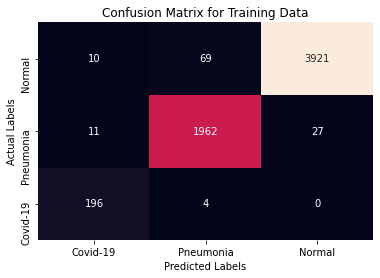

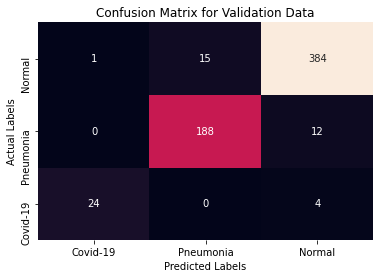

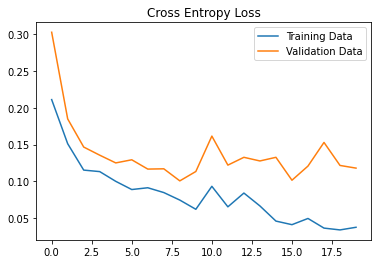

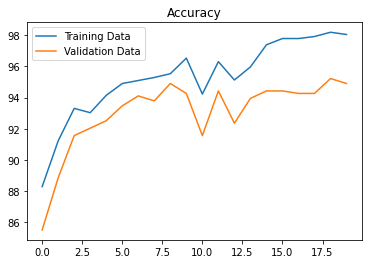

In [0]:
Epochs = 20
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
filename = './gdrive/My Drive/weights/vgg16_BCE_loss.pth'
train_model(vgg16, Epochs,trainloader, validationloader, optimizer, criterion, filename)

### Multilabel Confusion Matrix

Predicting Images: (100%): : 310it [01:53,  2.72it/s]


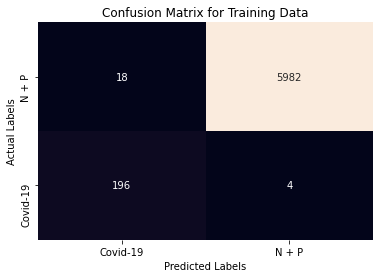

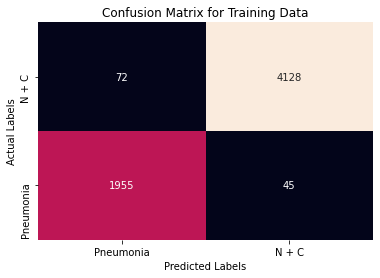

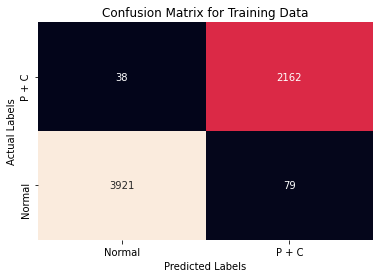

Predicting Images: (97%): : 32it [00:12,  2.49it/s]


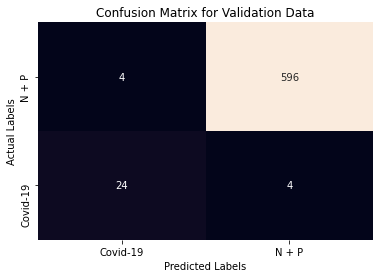

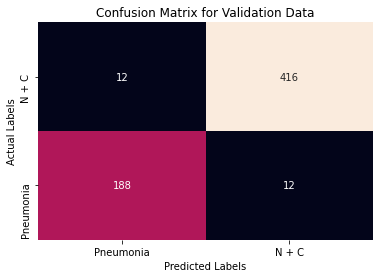

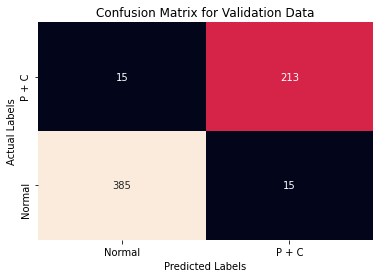

In [23]:
# Loading Model
vgg16.load_state_dict(torch.load('./gdrive/My Drive/Assignments/Deep Learning/Assignment 5/Part 2 Weights/vgg16_BCE_loss.pth',map_location=device))

yt,yp = predict_images(trainloader,vgg16)
cm = multilabel_confusion_matrix(yt,yp)

sns.heatmap(pd.DataFrame(cm[0],['N + P','Covid-19'],['N + P','Covid-19']), annot=True, fmt='g', cbar=False)
plt.title('Confusion Matrix for Training Data')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.xlim(reversed(plt.xlim()))
plt.show()

sns.heatmap(pd.DataFrame(cm[1],['N + C','Pneumonia'],['N + C','Pneumonia']), annot=True, fmt='g', cbar=False)
plt.title('Confusion Matrix for Training Data')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.xlim(reversed(plt.xlim()))
plt.show()

sns.heatmap(pd.DataFrame(cm[2],['P + C','Normal'],['P + C','Normal']), annot=True, fmt='g', cbar=False)
plt.title('Confusion Matrix for Training Data')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.xlim(reversed(plt.xlim()))
plt.show()

yt,yp = predict_images(validationloader,vgg16)
cm = multilabel_confusion_matrix(yt,yp)

sns.heatmap(pd.DataFrame(cm[0],['N + P','Covid-19'],['N + P','Covid-19']), annot=True, fmt='g', cbar=False)
plt.title('Confusion Matrix for Validation Data')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.xlim(reversed(plt.xlim()))
plt.show()

sns.heatmap(pd.DataFrame(cm[1],['N + C','Pneumonia'],['N + C','Pneumonia']), annot=True, fmt='g', cbar=False)
plt.title('Confusion Matrix for Validation Data')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.xlim(reversed(plt.xlim()))
plt.show()

sns.heatmap(pd.DataFrame(cm[2],['P + C','Normal'],['P + C','Normal']), annot=True, fmt='g', cbar=False)
plt.title('Confusion Matrix for Validation Data')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.xlim(reversed(plt.xlim()))
plt.show()

#### Classifying Unlabeled Test Data

In [25]:
_,tp = predict_images(testloader,vgg16)
df =  pd.DataFrame(onehot(tp,[0,1,2]).tolist()).astype(int)
df.columns = ['Covid-19','Pneumonia','Normal']
df.index = image_names

Predicting Images: (97%): : 32it [00:13,  2.29it/s]


In [26]:
print('Model has predicted ',df[df['Covid-19']==1].count()[0],' X-Ray images of covid-19 infected people.')
print('Model has predicted ',df[df['Pneumonia']==1].count()[0],' X-Ray images of Pneumonia infected people including covid-19 as covid-19 is also a type of Pneumonia.')
print('Model has predicted ',df[df['Normal']==1].count()[0],' X-Ray images of normal people.')

Model has predicted  26  X-Ray images of covid-19 infected people.
Model has predicted  243  X-Ray images of Pneumonia infected people including covid-19 as covid-19 is also a type of Pneumonia.
Model has predicted  386  X-Ray images of normal people.


In [27]:
df.head(10)

,Covid-19,Pneumonia,Normal
0,0,0,1
1,0,0,1
10,0,0,1
100,0,1,0
101,0,0,1
102,0,0,1
103,0,1,0
104,0,1,0
105,1,1,0
106,0,0,1


In [0]:
df.to_csv('./gdrive/My Drive/weights/vgg16_BCE_loss.csv',header=False)

### ResNet-18

#### Loading Model

In [29]:
res18 = models.resnet18(pretrained=True)
features = []
num_features = 512
num_classes = 3
features.extend([nn.Linear(num_features, num_classes)])
res18.fc = nn.Sequential(*features)
print(res18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

#### Training Model

Training Epoch: 1, Loss 0.10667683929204941,(100%): : 310it [01:52,  2.74it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:46,  2.90it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.79it/s]



Training Accuracy =  91.0 
Training Loss =  0.15540519661961064 
Validation Accuracy =  90.60509554140127 
Validation Loss =  0.16947859374340624 



Training Epoch: 2, Loss 0.2913232445716858,(100%): : 310it [01:53,  2.74it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:46,  2.90it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.84it/s]



Training Accuracy =  91.85483870967742 
Training Loss =  0.14086193531871805 
Validation Accuracy =  92.51592356687898 
Validation Loss =  0.14665422297548503 



Training Epoch: 3, Loss 0.33176079392433167,(100%): : 310it [01:53,  2.72it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:45,  2.93it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.85it/s]


Training Accuracy =  92.96774193548387 
Training Loss =  0.12313880771398544 
Validation Accuracy =  93.15286624203821 
Validation Loss =  0.14905844687018543 




Training Epoch: 4, Loss 0.021776029840111732,(100%): : 310it [01:52,  2.75it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:46,  2.92it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.85it/s]


Training Accuracy =  93.69354838709677 
Training Loss =  0.11076872502904266 
Validation Accuracy =  92.51592356687898 
Validation Loss =  0.14260943362023681 




Training Epoch: 5, Loss 0.06266090273857117,(100%): : 310it [01:53,  2.74it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:46,  2.92it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.80it/s]


Training Accuracy =  95.56451612903226 
Training Loss =  0.08765975559851336 
Validation Accuracy =  95.38216560509554 
Validation Loss =  0.10521188797429204 




Training Epoch: 6, Loss 0.18931379914283752,(100%): : 310it [01:53,  2.73it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:46,  2.91it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.82it/s]


Training Accuracy =  93.85483870967742 
Training Loss =  0.10522736821984571 
Validation Accuracy =  91.56050955414013 
Validation Loss =  0.15637475857511163 




Training Epoch: 7, Loss 0.13802500069141388,(100%): : 310it [01:53,  2.73it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:46,  2.92it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.80it/s]


Training Accuracy =  95.70967741935485 
Training Loss =  0.07349872944666253 
Validation Accuracy =  94.90445859872611 
Validation Loss =  0.09810421260772273 




Training Epoch: 8, Loss 0.048769962042570114,(100%): : 310it [01:54,  2.72it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:47,  2.88it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.84it/s]


Training Accuracy =  95.74193548387096 
Training Loss =  0.07739700947798067 
Validation Accuracy =  93.78980891719745 
Validation Loss =  0.11098470716387965 




Training Epoch: 9, Loss 0.11770414561033249,(100%): : 310it [01:54,  2.71it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:47,  2.89it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.79it/s]


Training Accuracy =  95.80645161290322 
Training Loss =  0.08716025634278213 
Validation Accuracy =  93.94904458598727 
Validation Loss =  0.12713944329880178 




Training Epoch: 10, Loss 0.28943511843681335,(100%): : 310it [01:54,  2.71it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:47,  2.89it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.79it/s]


Training Accuracy =  96.12903225806451 
Training Loss =  0.06830172915342114 
Validation Accuracy =  93.94904458598727 
Validation Loss =  0.1508604528644355 




Training Epoch: 11, Loss 0.04669167101383209,(100%): : 310it [01:53,  2.72it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:46,  2.91it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.78it/s]


Training Accuracy =  95.75806451612904 
Training Loss =  0.07197295249695139 
Validation Accuracy =  94.10828025477707 
Validation Loss =  0.12797542588668875 




Training Epoch: 12, Loss 0.02098059095442295,(100%): : 310it [01:54,  2.72it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:46,  2.90it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.79it/s]


Training Accuracy =  97.43548387096774 
Training Loss =  0.04565643173296966 
Validation Accuracy =  94.26751592356688 
Validation Loss =  0.14834478058037348 




Training Epoch: 13, Loss 0.012362346053123474,(100%): : 310it [01:54,  2.71it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:47,  2.87it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.82it/s]


Training Accuracy =  97.54838709677419 
Training Loss =  0.05115351748742884 
Validation Accuracy =  93.94904458598727 
Validation Loss =  0.13203044948750176 




Training Epoch: 14, Loss 0.054941415786743164,(100%): : 310it [01:55,  2.69it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:47,  2.89it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.79it/s]


Training Accuracy =  97.01612903225806 
Training Loss =  0.050266589730932947 
Validation Accuracy =  94.42675159235668 
Validation Loss =  0.12257266201777384 




Training Epoch: 15, Loss 0.0057922909036278725,(100%): : 310it [01:53,  2.74it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:45,  2.93it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.86it/s]


Training Accuracy =  97.38709677419355 
Training Loss =  0.04706683603731254 
Validation Accuracy =  94.26751592356688 
Validation Loss =  0.11353188255452551 




Training Epoch: 16, Loss 0.022055309265851974,(100%): : 310it [01:52,  2.75it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:46,  2.90it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.88it/s]


Training Accuracy =  98.19354838709677 
Training Loss =  0.034846970959540244 
Validation Accuracy =  95.06369426751591 
Validation Loss =  0.12584912404417992 




Training Epoch: 17, Loss 0.009975356981158257,(100%): : 310it [01:53,  2.73it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:45,  2.95it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:10,  2.91it/s]


Training Accuracy =  97.56451612903226 
Training Loss =  0.04384296023016495 
Validation Accuracy =  94.7452229299363 
Validation Loss =  0.13188199455908034 




Training Epoch: 18, Loss 0.04652677848935127,(100%): : 310it [01:52,  2.76it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:46,  2.91it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.84it/s]


Training Accuracy =  98.46774193548387 
Training Loss =  0.030001630640453508 
Validation Accuracy =  95.85987261146497 
Validation Loss =  0.13474454858805984 




Training Epoch: 19, Loss 0.0017866415437310934,(100%): : 310it [01:52,  2.76it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:45,  2.93it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.86it/s]



Training Accuracy =  97.03225806451613 
Training Loss =  0.05730833767053311 
Validation Accuracy =  93.31210191082803 
Validation Loss =  0.14980806811945513 



Training Epoch: 20, Loss 0.12237487733364105,(100%): : 310it [01:52,  2.75it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:46,  2.90it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.78it/s]



Training Accuracy =  97.95161290322581 
Training Loss =  0.03568422685362278 
Validation Accuracy =  95.22292993630573 
Validation Loss =  0.11628339523304021 

Final Stats:

                     Loss   Accuracy  Precision     Recall   F1_Score
Training Scores  0.035684  97.951613  97.651202  97.951613  97.811855

                       Loss  Accuracy  Precision    Recall  F1_Score
Validation Scores  0.116283  95.22293  95.337063  95.22293  95.27344



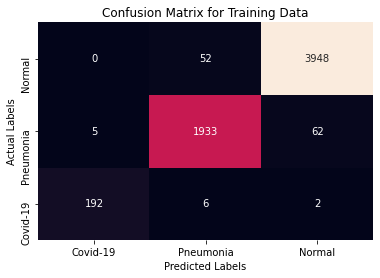

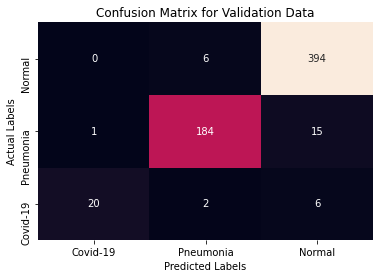

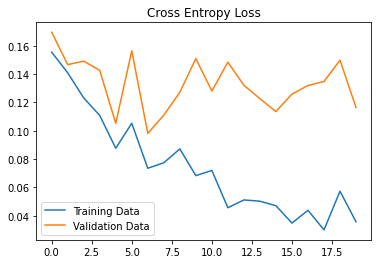

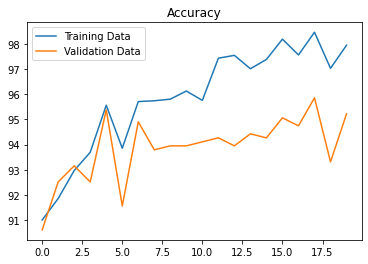

In [0]:
Epochs = 20
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(res18.parameters(), lr=0.01, momentum=0.9)
filename = './gdrive/My Drive/weights/res18_BCE_loss.pth'
train_model(res18, Epochs,trainloader, validationloader, optimizer, criterion, filename)

### Multilabel Confusion Matrix

Predicting Images: (100%): : 310it [01:43,  2.99it/s]


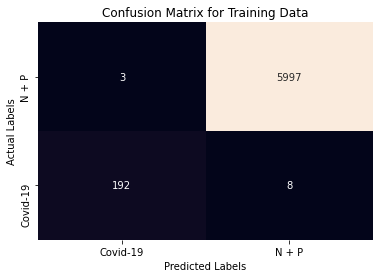

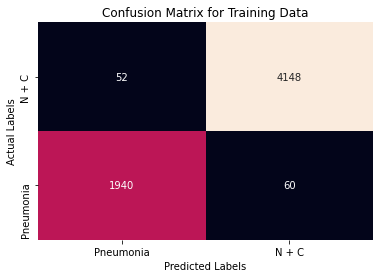

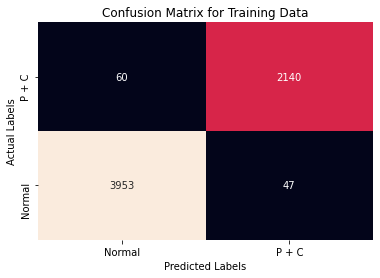

Predicting Images: (97%): : 32it [00:11,  2.90it/s]


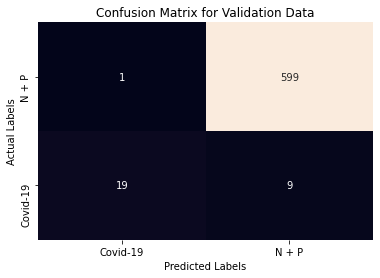

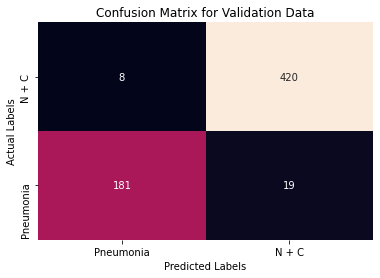

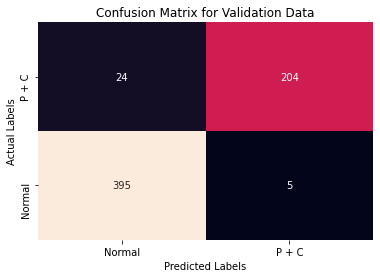

In [31]:
# Loading Model
res18.load_state_dict(torch.load('./gdrive/My Drive/Assignments/Deep Learning/Assignment 5/Part 2 Weights/res18_BCE_loss.pth',map_location=device))

yt,yp = predict_images(trainloader,res18)
cm = multilabel_confusion_matrix(yt,yp)

sns.heatmap(pd.DataFrame(cm[0],['N + P','Covid-19'],['N + P','Covid-19']), annot=True, fmt='g', cbar=False)
plt.title('Confusion Matrix for Training Data')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.xlim(reversed(plt.xlim()))
plt.show()

sns.heatmap(pd.DataFrame(cm[1],['N + C','Pneumonia'],['N + C','Pneumonia']), annot=True, fmt='g', cbar=False)
plt.title('Confusion Matrix for Training Data')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.xlim(reversed(plt.xlim()))
plt.show()

sns.heatmap(pd.DataFrame(cm[2],['P + C','Normal'],['P + C','Normal']), annot=True, fmt='g', cbar=False)
plt.title('Confusion Matrix for Training Data')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.xlim(reversed(plt.xlim()))
plt.show()

yt,yp = predict_images(validationloader,res18)
cm = multilabel_confusion_matrix(yt,yp)

sns.heatmap(pd.DataFrame(cm[0],['N + P','Covid-19'],['N + P','Covid-19']), annot=True, fmt='g', cbar=False)
plt.title('Confusion Matrix for Validation Data')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.xlim(reversed(plt.xlim()))
plt.show()

sns.heatmap(pd.DataFrame(cm[1],['N + C','Pneumonia'],['N + C','Pneumonia']), annot=True, fmt='g', cbar=False)
plt.title('Confusion Matrix for Validation Data')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.xlim(reversed(plt.xlim()))
plt.show()

sns.heatmap(pd.DataFrame(cm[2],['P + C','Normal'],['P + C','Normal']), annot=True, fmt='g', cbar=False)
plt.title('Confusion Matrix for Validation Data')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.xlim(reversed(plt.xlim()))
plt.show()

#### Classifying Unlabeled Test Data

In [33]:
_,tp = predict_images(testloader,res18)
df =  pd.DataFrame(onehot(tp,[0,1,2]).tolist()).astype(int)
df.columns = ['Covid-19','Pneumonia','Normal']
df.index = image_names

Predicting Images: (97%): : 32it [00:10,  2.98it/s]


In [34]:
print('Model has predicted ',df[df['Covid-19']==1].count()[0],' X-Ray images of covid-19 infected people.')
print('Model has predicted ',df[df['Pneumonia']==1].count()[0],' X-Ray images of Pneumonia infected people including covid-19 as covid-19 is also a type of Pneumonia.')
print('Model has predicted ',df[df['Normal']==1].count()[0],' X-Ray images of normal people.')

Model has predicted  25  X-Ray images of covid-19 infected people.
Model has predicted  212  X-Ray images of Pneumonia infected people including covid-19 as covid-19 is also a type of Pneumonia.
Model has predicted  417  X-Ray images of normal people.


In [35]:
df.head(10)

,Covid-19,Pneumonia,Normal
0,0,0,1
1,0,0,1
10,0,0,1
100,0,0,1
101,0,0,1
102,0,0,1
103,0,0,1
104,0,1,0
105,1,1,0
106,0,0,1


In [0]:
df.to_csv('./gdrive/My Drive/weights/res18_BCE_loss.csv',header=False)

## Task 2

### VGG-16

#### Loading Model

In [37]:
vgg16 = models.vgg16(pretrained=True)
features = []
num_features = 1024
num_classes = 3
features.extend([nn.Linear(25088, num_features)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout()])
features.extend([nn.Linear(num_features, num_classes)])
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
print('Following Parameters/Features are freezed:')
for name, param in vgg16.named_parameters():
    if param.requires_grad==False:
        print(name)
print('\nFollowing Parameters/Features will be trained:')
for name, param in vgg16.named_parameters():
    if param.requires_grad==True:
        print(name)

Following Parameters/Features are freezed:

Following Parameters/Features will be trained:
features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


#### Training Model

Training Epoch: 1, Loss 0.8124152421951294,(100%): : 310it [03:47,  1.36it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:55,  2.68it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.38it/s]


Training Accuracy =  83.75806451612902 
Training Loss =  1.0770692439809921 
Validation Accuracy =  83.7579617834395 
Validation Loss =  1.3071425817906857 




Training Epoch: 2, Loss 0.7962868213653564,(100%): : 310it [03:46,  1.37it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:56,  2.66it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.42it/s]


Training Accuracy =  87.53225806451613 
Training Loss =  0.8626217940641988 
Validation Accuracy =  85.828025477707 
Validation Loss =  1.0323983617126942 




Training Epoch: 3, Loss 1.2276020050048828,(100%): : 310it [03:48,  1.36it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:54,  2.72it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.39it/s]


Training Accuracy =  88.38709677419355 
Training Loss =  0.8759723205239542 
Validation Accuracy =  88.05732484076432 
Validation Loss =  1.1941826436668634 




Training Epoch: 4, Loss 0.5864930748939514,(100%): : 310it [03:48,  1.36it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:53,  2.74it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:12,  2.46it/s]



Training Accuracy =  90.1774193548387 
Training Loss =  1.2174051814862796 
Validation Accuracy =  89.01273885350318 
Validation Loss =  1.7592867174535058 



Training Epoch: 5, Loss 1.3338277339935303,(100%): : 310it [03:46,  1.37it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:54,  2.72it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.30it/s]



Training Accuracy =  84.41935483870968 
Training Loss =  0.9228567391633987 
Validation Accuracy =  84.55414012738854 
Validation Loss =  0.9744645771570504 



Training Epoch: 6, Loss 1.270317792892456,(100%): : 310it [03:47,  1.36it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:56,  2.66it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.36it/s]


Training Accuracy =  91.11290322580645 
Training Loss =  0.6078647959857217 
Validation Accuracy =  90.28662420382165 
Validation Loss =  0.8178675028029829 




Training Epoch: 7, Loss 0.6553666591644287,(100%): : 310it [03:47,  1.36it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:55,  2.68it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.36it/s]


Training Accuracy =  89.01612903225806 
Training Loss =  0.6949908657420066 
Validation Accuracy =  89.64968152866241 
Validation Loss =  0.8091058097779751 




Training Epoch: 8, Loss 0.6489510536193848,(100%): : 310it [03:46,  1.37it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:54,  2.71it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.43it/s]


Training Accuracy =  91.8225806451613 
Training Loss =  0.5815998299467948 
Validation Accuracy =  91.0828025477707 
Validation Loss =  0.9086532148066908 




Training Epoch: 9, Loss 0.5842135548591614,(100%): : 310it [03:47,  1.37it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:53,  2.74it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.31it/s]


Training Accuracy =  92.40322580645162 
Training Loss =  0.47562495524123793 
Validation Accuracy =  90.76433121019109 
Validation Loss =  0.849643399589695 




Training Epoch: 10, Loss 0.12838420271873474,(100%): : 310it [03:46,  1.37it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:54,  2.71it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.45it/s]



Training Accuracy =  92.75806451612904 
Training Loss =  0.4202032549967689 
Validation Accuracy =  90.92356687898089 
Validation Loss =  0.9166907694889233 



Training Epoch: 11, Loss 0.3900282382965088,(100%): : 310it [03:46,  1.37it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:52,  2.75it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.42it/s]



Training Accuracy =  94.83870967741936 
Training Loss =  0.40086006960501114 
Validation Accuracy =  93.15286624203821 
Validation Loss =  0.9959052347112447 



Training Epoch: 12, Loss 0.08012895286083221,(100%): : 310it [03:46,  1.37it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:54,  2.72it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:12,  2.48it/s]


Training Accuracy =  90.03225806451613 
Training Loss =  0.9617538816505863 
Validation Accuracy =  87.42038216560509 
Validation Loss =  2.2764685613801703 




Training Epoch: 13, Loss 0.5069019198417664,(100%): : 310it [03:46,  1.37it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:56,  2.66it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:14,  2.24it/s]


Training Accuracy =  95.04838709677419 
Training Loss =  0.31515691918471167 
Validation Accuracy =  92.35668789808918 
Validation Loss =  0.9506842059054179 




Training Epoch: 14, Loss 0.32137247920036316,(100%): : 310it [03:46,  1.37it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:57,  2.64it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.43it/s]


Training Accuracy =  94.11290322580645 
Training Loss =  0.47011126938065695 
Validation Accuracy =  92.03821656050955 
Validation Loss =  1.5724721958686132 




Training Epoch: 15, Loss 0.5621188282966614,(100%): : 310it [03:46,  1.37it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:55,  2.67it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:14,  2.24it/s]



Training Accuracy =  90.88709677419354 
Training Loss =  0.49327995486317144 
Validation Accuracy =  86.78343949044586 
Validation Loss =  0.9205939429812133 



Training Epoch: 16, Loss 0.7323592901229858,(100%): : 310it [03:46,  1.37it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:55,  2.68it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.37it/s]


Training Accuracy =  95.90322580645162 
Training Loss =  0.2832811215291581 
Validation Accuracy =  92.67515923566879 
Validation Loss =  1.0359940336202271 




Training Epoch: 17, Loss 0.20157401263713837,(100%): : 310it [03:46,  1.37it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [02:01,  2.54it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:14,  2.23it/s]


Training Accuracy =  96.48387096774194 
Training Loss =  0.2554211599752307 
Validation Accuracy =  93.15286624203821 
Validation Loss =  0.8354194115381688 




Training Epoch: 18, Loss 0.1275959312915802,(100%): : 310it [03:47,  1.36it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:58,  2.61it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:14,  2.24it/s]


Training Accuracy =  96.30645161290322 
Training Loss =  0.2862652813985703 
Validation Accuracy =  94.10828025477707 
Validation Loss =  1.4843529169738758 




Training Epoch: 19, Loss 0.01848282851278782,(100%): : 310it [03:46,  1.37it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:57,  2.63it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.42it/s]


Training Accuracy =  97.40322580645162 
Training Loss =  0.23538593512437786 
Validation Accuracy =  93.78980891719745 
Validation Loss =  1.8251369035460812 




Training Epoch: 20, Loss 0.4222063720226288,(100%): : 310it [03:48,  1.36it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:59,  2.59it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:13,  2.39it/s]



Training Accuracy =  96.74193548387096 
Training Loss =  0.252794235358916 
Validation Accuracy =  94.5859872611465 
Validation Loss =  0.9756916123442352 

Final Stats:

                     Loss   Accuracy  Precision     Recall   F1_Score
Training Scores  0.252794  96.741935  85.341754  96.741935  91.176544

                       Loss   Accuracy  Precision     Recall   F1_Score
Validation Scores  0.975692  94.585987  86.457649  94.585987  90.612875



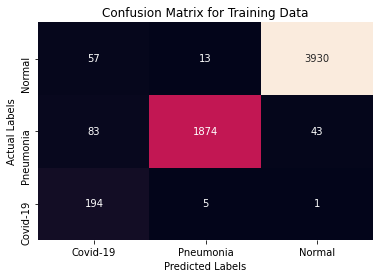

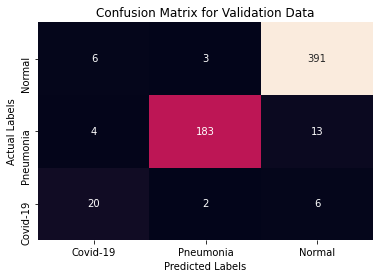

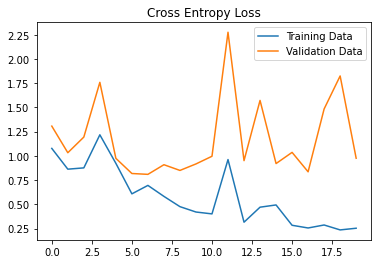

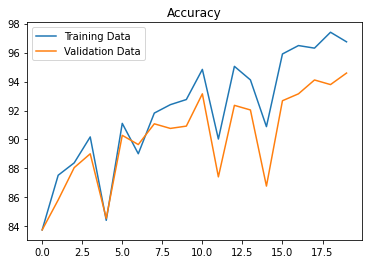

In [0]:
Epochs = 20
criterion = Focal_Loss
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.3)
filename = './gdrive/My Drive/weights/vgg16_focal_loss.pth'
train_model(vgg16, Epochs,trainloader, validationloader, optimizer, criterion, filename)

### Multilabel Confusion Matrix

Predicting Images: (100%): : 310it [01:53,  2.72it/s]


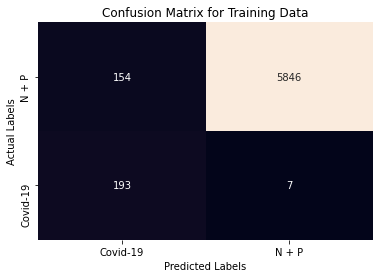

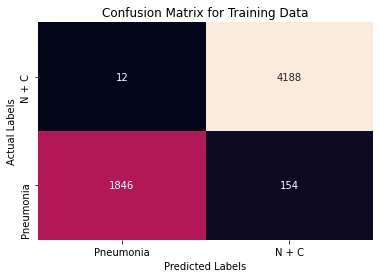

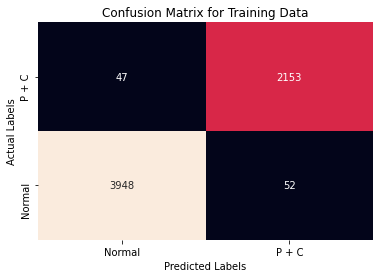

Predicting Images: (97%): : 32it [00:13,  2.33it/s]


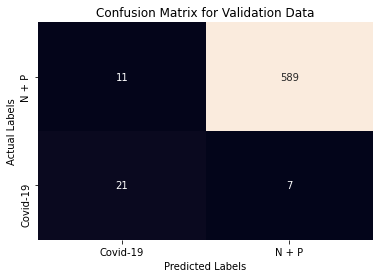

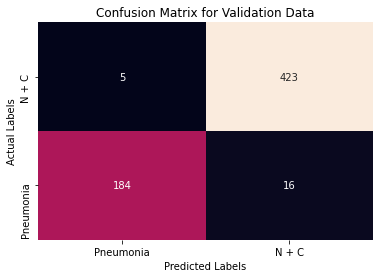

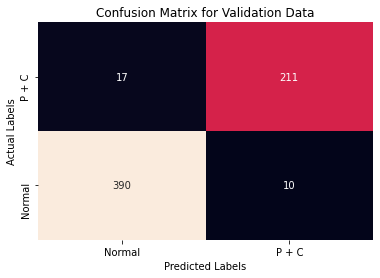

In [39]:
# Loading Model
vgg16.load_state_dict(torch.load('./gdrive/My Drive/Assignments/Deep Learning/Assignment 5/Part 2 Weights/vgg16_focal_loss.pth',map_location=device))

yt,yp = predict_images(trainloader,vgg16)
cm = multilabel_confusion_matrix(yt,yp)

sns.heatmap(pd.DataFrame(cm[0],['N + P','Covid-19'],['N + P','Covid-19']), annot=True, fmt='g', cbar=False)
plt.title('Confusion Matrix for Training Data')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.xlim(reversed(plt.xlim()))
plt.show()

sns.heatmap(pd.DataFrame(cm[1],['N + C','Pneumonia'],['N + C','Pneumonia']), annot=True, fmt='g', cbar=False)
plt.title('Confusion Matrix for Training Data')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.xlim(reversed(plt.xlim()))
plt.show()

sns.heatmap(pd.DataFrame(cm[2],['P + C','Normal'],['P + C','Normal']), annot=True, fmt='g', cbar=False)
plt.title('Confusion Matrix for Training Data')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.xlim(reversed(plt.xlim()))
plt.show()

yt,yp = predict_images(validationloader,vgg16)
cm = multilabel_confusion_matrix(yt,yp)

sns.heatmap(pd.DataFrame(cm[0],['N + P','Covid-19'],['N + P','Covid-19']), annot=True, fmt='g', cbar=False)
plt.title('Confusion Matrix for Validation Data')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.xlim(reversed(plt.xlim()))
plt.show()

sns.heatmap(pd.DataFrame(cm[1],['N + C','Pneumonia'],['N + C','Pneumonia']), annot=True, fmt='g', cbar=False)
plt.title('Confusion Matrix for Validation Data')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.xlim(reversed(plt.xlim()))
plt.show()

sns.heatmap(pd.DataFrame(cm[2],['P + C','Normal'],['P + C','Normal']), annot=True, fmt='g', cbar=False)
plt.title('Confusion Matrix for Validation Data')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.xlim(reversed(plt.xlim()))
plt.show()

#### Classifying Unlabeled Test Data

In [40]:
_,tp = predict_images(testloader,vgg16)
df =  pd.DataFrame(onehot(tp,[0,1,2]).tolist()).astype(int)
df.columns = ['Covid-19','Pneumonia','Normal']
df.index = image_names

Predicting Images: (97%): : 32it [00:13,  2.42it/s]


In [41]:
print('Model has predicted ',df[df['Covid-19']==1].count()[0],' X-Ray images of covid-19 infected people.')
print('Model has predicted ',df[df['Pneumonia']==1].count()[0],' X-Ray images of Pneumonia infected people including covid-19 as covid-19 is also a type of Pneumonia.')
print('Model has predicted ',df[df['Normal']==1].count()[0],' X-Ray images of normal people.')

Model has predicted  40  X-Ray images of covid-19 infected people.
Model has predicted  225  X-Ray images of Pneumonia infected people including covid-19 as covid-19 is also a type of Pneumonia.
Model has predicted  404  X-Ray images of normal people.


In [42]:
df.head(10)

,Covid-19,Pneumonia,Normal
0,0,0,1
1,0,0,1
10,0,0,1
100,0,0,1
101,0,0,1
102,0,0,1
103,0,0,1
104,0,1,0
105,1,1,0
106,0,0,1


In [0]:
df.to_csv('./gdrive/My Drive/weights/vgg16_focal_loss.csv',header=False)

### ResNet-18

#### Loading Model

In [44]:
res18 = models.resnet18(pretrained=True)
features = []
num_features = 512
num_classes = 3
features.extend([nn.Linear(num_features, num_classes)])
res18.fc = nn.Sequential(*features)
print(res18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
print('Following Parameters/Features are freezed:')
for name, param in res18.named_parameters():
    if param.requires_grad==False:
        print(name)
print('\nFollowing Parameters/Features will be trained:')
for name, param in res18.named_parameters():
    if param.requires_grad==True:
        print(name)

Following Parameters/Features are freezed:

Following Parameters/Features will be trained:
conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
laye

#### Training Model

Training Epoch: 1, Loss 0.7999830842018127,(100%): : 310it [01:52,  2.75it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:45,  2.94it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.86it/s]


Training Accuracy =  80.74193548387096 
Training Loss =  1.2960667319836154 
Validation Accuracy =  79.45859872611464 
Validation Loss =  1.4683974804356694 




Training Epoch: 2, Loss 1.6678671836853027,(100%): : 310it [01:53,  2.72it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:44,  2.96it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.89it/s]


Training Accuracy =  84.66129032258064 
Training Loss =  1.0022214476139315 
Validation Accuracy =  84.23566878980891 
Validation Loss =  1.0281680151820183 




Training Epoch: 3, Loss 0.6758624315261841,(100%): : 310it [01:53,  2.73it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:46,  2.92it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.85it/s]


Training Accuracy =  88.83870967741936 
Training Loss =  0.8877371290518391 
Validation Accuracy =  88.85350318471338 
Validation Loss =  0.9910909412428737 




Training Epoch: 4, Loss 0.5188703536987305,(100%): : 310it [01:54,  2.72it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:47,  2.88it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.79it/s]


Training Accuracy =  87.74193548387098 
Training Loss =  0.7858225700355346 
Validation Accuracy =  88.69426751592357 
Validation Loss =  0.9948705327697098 




Training Epoch: 5, Loss 2.1140084266662598,(100%): : 310it [01:52,  2.76it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:45,  2.93it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.80it/s]


Training Accuracy =  90.01612903225806 
Training Loss =  0.6605415176960729 
Validation Accuracy =  89.80891719745223 
Validation Loss =  0.904671065043658 




Training Epoch: 6, Loss 0.23798079788684845,(100%): : 310it [01:53,  2.73it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:47,  2.88it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.85it/s]


Training Accuracy =  89.62903225806451 
Training Loss =  0.6295235600682997 
Validation Accuracy =  89.96815286624204 
Validation Loss =  1.0536446359474212 




Training Epoch: 7, Loss 0.16759644448757172,(100%): : 310it [01:55,  2.68it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:47,  2.89it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.80it/s]


Training Accuracy =  88.85483870967742 
Training Loss =  0.5933460762183512 
Validation Accuracy =  87.73885350318471 
Validation Loss =  0.7755659683607519 




Training Epoch: 8, Loss 0.7999929785728455,(100%): : 310it [01:54,  2.71it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:46,  2.90it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.83it/s]



Training Accuracy =  93.2258064516129 
Training Loss =  0.5319978398180777 
Validation Accuracy =  92.35668789808918 
Validation Loss =  0.9473215260077268 



Training Epoch: 9, Loss 0.598397970199585,(100%): : 310it [01:52,  2.75it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:47,  2.89it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.80it/s]


Training Accuracy =  93.37096774193549 
Training Loss =  0.45052353176738946 
Validation Accuracy =  92.19745222929936 
Validation Loss =  0.7806661583017558 




Training Epoch: 10, Loss 0.2719850540161133,(100%): : 310it [01:55,  2.69it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:46,  2.90it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.80it/s]


Training Accuracy =  94.83870967741936 
Training Loss =  0.3803945549253014 
Validation Accuracy =  92.51592356687898 
Validation Loss =  1.0399621829856187 




Training Epoch: 11, Loss 1.2447397708892822,(100%): : 310it [01:52,  2.75it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:46,  2.91it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.84it/s]


Training Accuracy =  80.04838709677419 
Training Loss =  0.8045814846311846 
Validation Accuracy =  78.343949044586 
Validation Loss =  1.164767600595951 




Training Epoch: 12, Loss 0.18758755922317505,(100%): : 310it [01:53,  2.73it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:45,  2.94it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.75it/s]



Training Accuracy =  95.4032258064516 
Training Loss =  0.35819890257271547 
Validation Accuracy =  92.51592356687898 
Validation Loss =  1.1618280962575227 



Training Epoch: 13, Loss 0.3339522182941437,(100%): : 310it [01:54,  2.70it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:46,  2.90it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.91it/s]


Training Accuracy =  95.61290322580646 
Training Loss =  0.29638546694130186 
Validation Accuracy =  91.87898089171973 
Validation Loss =  0.8206435083411634 




Training Epoch: 14, Loss 1.2386984825134277,(100%): : 310it [01:52,  2.75it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:46,  2.92it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.83it/s]


Training Accuracy =  92.98387096774194 
Training Loss =  0.4705273773070545 
Validation Accuracy =  90.44585987261146 
Validation Loss =  1.2628694038285175 




Training Epoch: 15, Loss 0.521742582321167,(100%): : 310it [01:53,  2.72it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:45,  2.93it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.83it/s]


Training Accuracy =  95.16129032258065 
Training Loss =  0.34119188307874626 
Validation Accuracy =  90.44585987261146 
Validation Loss =  0.9906954233301803 




Training Epoch: 16, Loss 0.022579479962587357,(100%): : 310it [01:54,  2.72it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:48,  2.86it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.83it/s]


Training Accuracy =  94.70967741935485 
Training Loss =  0.36435139056956095 
Validation Accuracy =  91.0828025477707 
Validation Loss =  1.260660122614354 




Training Epoch: 17, Loss 0.5799390077590942,(100%): : 310it [01:54,  2.71it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:48,  2.85it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.82it/s]


Training Accuracy =  94.5 
Training Loss =  0.3948011262762931 
Validation Accuracy =  90.60509554140127 
Validation Loss =  1.0805671596899629 




Training Epoch: 18, Loss 0.16833144426345825,(100%): : 310it [01:54,  2.71it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:47,  2.88it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.85it/s]


Training Accuracy =  96.79032258064517 
Training Loss =  0.2150771662592888 
Validation Accuracy =  91.71974522292994 
Validation Loss =  1.0704946035984904 




Training Epoch: 19, Loss 0.046809181571006775,(100%): : 310it [01:53,  2.73it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:46,  2.92it/s]


For validation data



Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.88it/s]


Training Accuracy =  96.03225806451613 
Training Loss =  0.2694420381809675 
Validation Accuracy =  93.47133757961782 
Validation Loss =  1.0352711619343609 




Training Epoch: 20, Loss 0.1325562447309494,(100%): : 310it [01:55,  2.68it/s]


For training data



Calculating Accuracy and Loss: (100%): : 310it [01:48,  2.84it/s]



For validation data


Calculating Accuracy and Loss: (97%): : 32it [00:11,  2.78it/s]



Training Accuracy =  95.87096774193549 
Training Loss =  0.26632386924879203 
Validation Accuracy =  91.87898089171973 
Validation Loss =  1.1246384545229375 

Final Stats:

                     Loss   Accuracy  Precision     Recall   F1_Score
Training Scores  0.266324  95.870968  82.255359  95.870968  88.973889

                       Loss   Accuracy  Precision     Recall   F1_Score
Validation Scores  1.124638  91.878981  78.846831  91.878981  85.480885



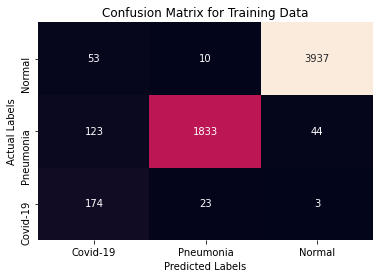

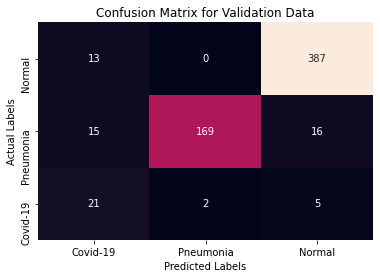

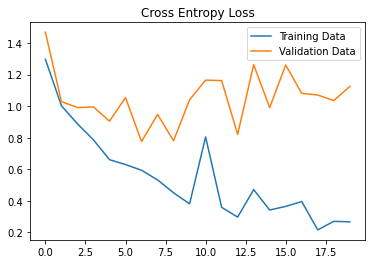

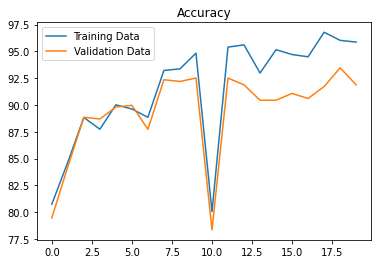

In [0]:
Epochs = 20
criterion = Focal_Loss
optimizer = optim.SGD(res18.parameters(), lr=0.001, momentum=0.7)
filename = './gdrive/My Drive/weights/res18_focal_loss.pth'
train_model(res18, Epochs,trainloader, validationloader, optimizer, criterion, filename)

### Multilabel Confusion Matrix

Predicting Images: (100%): : 310it [01:43,  2.99it/s]


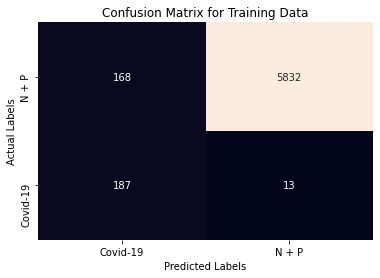

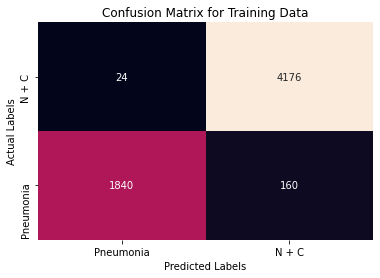

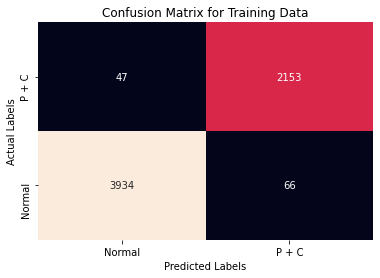

Predicting Images: (97%): : 32it [00:10,  2.92it/s]


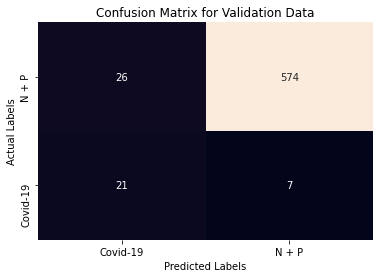

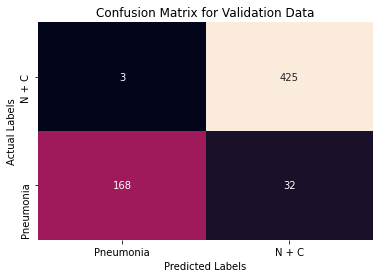

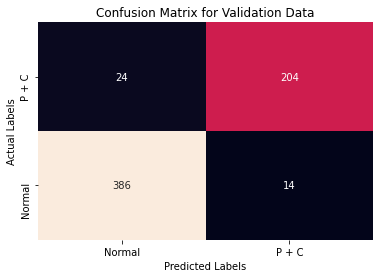

In [45]:
# Loading Model
res18.load_state_dict(torch.load('./gdrive/My Drive/Assignments/Deep Learning/Assignment 5/Part 2 Weights/res18_focal_loss.pth',map_location=device))

yt,yp = predict_images(trainloader,res18)
cm = multilabel_confusion_matrix(yt,yp)

sns.heatmap(pd.DataFrame(cm[0],['N + P','Covid-19'],['N + P','Covid-19']), annot=True, fmt='g', cbar=False)
plt.title('Confusion Matrix for Training Data')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.xlim(reversed(plt.xlim()))
plt.show()

sns.heatmap(pd.DataFrame(cm[1],['N + C','Pneumonia'],['N + C','Pneumonia']), annot=True, fmt='g', cbar=False)
plt.title('Confusion Matrix for Training Data')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.xlim(reversed(plt.xlim()))
plt.show()

sns.heatmap(pd.DataFrame(cm[2],['P + C','Normal'],['P + C','Normal']), annot=True, fmt='g', cbar=False)
plt.title('Confusion Matrix for Training Data')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.xlim(reversed(plt.xlim()))
plt.show()

yt,yp = predict_images(validationloader,res18)
cm = multilabel_confusion_matrix(yt,yp)

sns.heatmap(pd.DataFrame(cm[0],['N + P','Covid-19'],['N + P','Covid-19']), annot=True, fmt='g', cbar=False)
plt.title('Confusion Matrix for Validation Data')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.xlim(reversed(plt.xlim()))
plt.show()

sns.heatmap(pd.DataFrame(cm[1],['N + C','Pneumonia'],['N + C','Pneumonia']), annot=True, fmt='g', cbar=False)
plt.title('Confusion Matrix for Validation Data')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.xlim(reversed(plt.xlim()))
plt.show()

sns.heatmap(pd.DataFrame(cm[2],['P + C','Normal'],['P + C','Normal']), annot=True, fmt='g', cbar=False)
plt.title('Confusion Matrix for Validation Data')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.xlim(reversed(plt.xlim()))
plt.show()

#### Classifying Unlabeled Test Data

In [47]:
_,tp = predict_images(testloader,res18)
df =  pd.DataFrame(onehot(tp,[0,1,2]).tolist()).astype(int)
df.columns = ['Covid-19','Pneumonia','Normal']
df.index = image_names

Predicting Images: (97%): : 32it [00:10,  2.95it/s]


In [48]:
print('Model has predicted ',df[df['Covid-19']==1].count()[0],' X-Ray images of covid-19 infected people.')
print('Model has predicted ',df[df['Pneumonia']==1].count()[0],' X-Ray images of Pneumonia infected people including covid-19 as covid-19 is also a type of Pneumonia.')
print('Model has predicted ',df[df['Normal']==1].count()[0],' X-Ray images of normal people.')

Model has predicted  63  X-Ray images of covid-19 infected people.
Model has predicted  218  X-Ray images of Pneumonia infected people including covid-19 as covid-19 is also a type of Pneumonia.
Model has predicted  411  X-Ray images of normal people.


In [49]:
df.head(10)

,Covid-19,Pneumonia,Normal
0,0,0,1
1,0,0,1
10,0,0,1
100,0,0,1
101,0,0,1
102,0,0,1
103,0,0,1
104,0,0,1
105,1,1,0
106,0,0,1


In [0]:
df.to_csv('./gdrive/My Drive/weights/res18_focal_loss.csv',header=False)

In [0]:
# # To calculate Mean and Standard Deviation to normalize images 
# mean = []
# std = []
# for images, labels in trainloader:
#     numpy_images = images.numpy()
#     mean.append(np.mean(numpy_images, axis=(0, 2, 3)))
#     std.append(np.std(numpy_images, axis=(0, 2, 3)))    
# print(np.mean(np.array(mean),axis=0))
# print(np.mean(np.array(std),axis=0))